In [1]:
import string, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import jieba
import operator
import zhconv
from collections import Counter
import warnings
warnings.filterwarnings(action='ignore',category=UserWarning,module='gensim')

from gensim.models import Word2Vec

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model

In [2]:
comments_path = r'datasets/movie_comments.csv'
model_path = r'models/zhwiki.50d.word2vec'

# 影评数据

In [3]:
comments = pd.read_csv(comments_path, low_memory=False)
comments.head(10)

,id,link,name,comment,star
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,3,https://movie.douban.com/subject/26363254/,战狼2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,4,https://movie.douban.com/subject/26363254/,战狼2,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,5,https://movie.douban.com/subject/26363254/,战狼2,中二得很,1
5,6,https://movie.douban.com/subject/26363254/,战狼2,“犯我中华者，虽远必诛”，吴京比这句话还要意淫一百倍。,1
6,7,https://movie.douban.com/subject/26363254/,战狼2,脑子是个好东西，希望编剧们都能有。,2
7,8,https://movie.douban.com/subject/26363254/,战狼2,三星半，实打实的7分。第一集在爱国主旋律内部做着各种置换与较劲，但第二集才真正显露吴京的野心...,4
8,9,https://movie.douban.com/subject/26363254/,战狼2,开篇长镜头惊险大气引人入胜 结合了水平不俗的快剪下实打实的真刀真枪 让人不禁热血沸腾 特别弹...,4
9,10,https://movie.douban.com/subject/26363254/,战狼2,15/100吴京的冷峰在这部里即像成龙，又像杰森斯坦森，但体制外的同类型电影，主角总是代表个...,1


In [4]:
comments.drop(['id','link','name'], axis=1, inplace=True)
print(comments.info())
comments.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261497 entries, 0 to 261496
Data columns (total 2 columns):
comment    261495 non-null object
star       261497 non-null object
dtypes: object(2)
memory usage: 4.0+ MB
None


,comment,star
0,吴京意淫到了脑残的地步，看了恶心想吐,1
1,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,中二得很,1
5,“犯我中华者，虽远必诛”，吴京比这句话还要意淫一百倍。,1
6,脑子是个好东西，希望编剧们都能有。,2
7,三星半，实打实的7分。第一集在爱国主旋律内部做着各种置换与较劲，但第二集才真正显露吴京的野心...,4
8,开篇长镜头惊险大气引人入胜 结合了水平不俗的快剪下实打实的真刀真枪 让人不禁热血沸腾 特别弹...,4
9,15/100吴京的冷峰在这部里即像成龙，又像杰森斯坦森，但体制外的同类型电影，主角总是代表个...,1


#### 删除评论为空的行

In [5]:
comments = comments.dropna()
print(comments.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261495 entries, 0 to 261496
Data columns (total 2 columns):
comment    261495 non-null object
star       261495 non-null object
dtypes: object(2)
memory usage: 6.0+ MB
None


#### 删除评分不为数值的行

In [6]:
comments = comments[comments['star'].isin(['1', '2', '3', '4', '5'])]
print(comments.info())
comments['star'] = comments['star'].astype('int')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261494 entries, 0 to 261496
Data columns (total 2 columns):
comment    261494 non-null object
star       261494 non-null object
dtypes: object(2)
memory usage: 6.0+ MB
None


#### 查看评分分数分布:
- 不同类评分的分布比较不均匀，特别是 1、2 分
- **todo：处理这种不平衡**

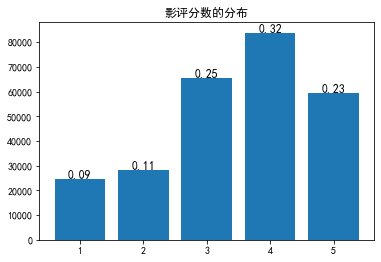

In [7]:
x = np.arange(1,6)
nums = [len(comments[comments['star']==i]) for i in x]

def plot_score_distribution(x, nums):
    plt.bar(x, nums)
   
    plt.title('影评分数的分布')
    for x,y in zip(x,nums):
        plt.text(x,y+100,round(y/sum(nums),2),ha='center',fontsize=12)
    plt.show()
    
plot_score_distribution(x, nums) 

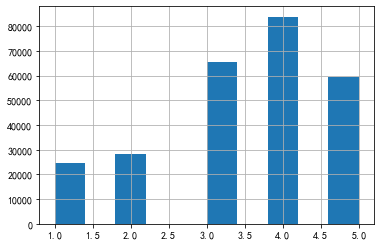

In [8]:
comments['star'].hist()

#### 文本预处理
- 删除符号
- 繁体转简体
- 分词后以空格连接
- 英文大写转小写

In [9]:
punct = r"，。！？、；：“”\n＂＃＄％＆＇（）＊＋－／＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､〃《》「」『』【】〔〕〖〗〘〙〚〛〜〝〟〰〾〿–—‛„‟…‧﹏★☆•→▽"


def clean_special_chars(text):
    re_tok = re.compile(f'([{string.punctuation}{punct}])')
    return re_tok.sub(r' ', text)


def simplify(text):
    return zhconv.convert(text, 'zh-cn')


def cut_join(text):
    space = ' '
    words = jieba.cut(text)
    return space.join([w.lower() for w in words if not w.isspace()])


def preprocess(text):
    text = clean_special_chars(text)
    text = simplify(text)
    text = cut_join(text)
    return text


comments['cleaned_comment'] = comments['comment'].apply(preprocess)

comments['cleaned_comment'].head(10)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.440 seconds.
Prefix dict has been built successfully.


0                         吴京 意淫 到 了 脑残 的 地步 看 了 恶心 想 吐
1    首映礼 看 的 太 恐怖 了 这个 电影 不讲道理 的 完全 就是 吴京 在 实现 他 这个...
2    吴京 的 炒作 水平 不输 冯小刚 但小刚 至少 不会 用 主旋律 来 炒作 吴京 让 人 ...
3                     凭良心说 好 看到 不像 战狼 1 的 续集 完虐 湄公河 行动
4                                                中二得 很
5                   犯 我 中华 者 虽远必 诛 吴京 比 这句 话 还要 意淫 一百倍
6                            脑子 是 个 好 东西 希望 编剧 们 都 能 有
7    三星 半 实打实 的 7 分 第一集 在 爱国 主旋律 内部 做 着 各种 置换 与 较劲 ...
8    开篇 长镜头 惊险 大气 引人入胜 结合 了 水平 不俗 的 快 剪下 实打实 的 真刀真枪...
9    15 100 吴京 的 冷峰 在 这部 里 即 像 成龙 又 像杰 森斯坦 森 但 体制 外...
Name: cleaned_comment, dtype: object

#### 查看影评的字数分布
- 5% 的影评字数少于 3 个，删除这些数据；删除后对类别分布无影响
- **todo：更好的方法处理不同影评的这种字数差别**

In [10]:
comments['comment_length'] = comments['comment'].apply(len).astype('int')

min_ = comments['comment_length'].min()
max_ = comments['comment_length'].max()
median = comments['comment_length'].median()
mean = comments['comment_length'].mean()
mode = comments['comment_length'].mode()[0]
print(min_, max_, median, mean, mode)

1 4247 19.0 34.62489770319778 7


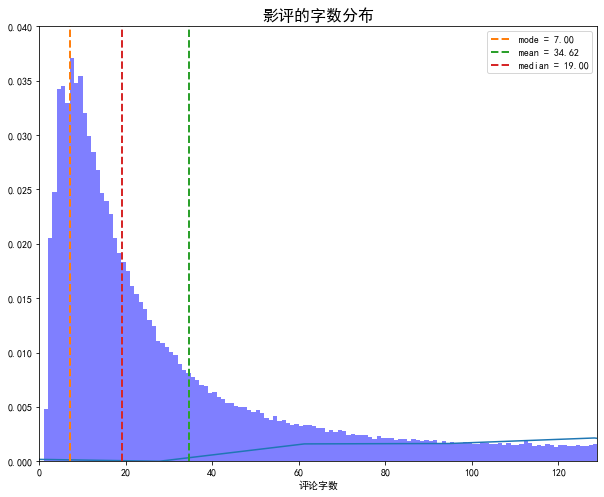

In [11]:
fig, ax = plt.subplots(figsize=(10,8))
sn.distplot(comments['comment_length'], bins=comments['comment_length'].max(),
            hist_kws={"alpha": 0.5, "color": "blue"}, ax=ax)
ax.set_xlim(left=0, right=np.percentile(comments['comment_length'], 95))
ax.set_xlabel('评论字数')
ymax = 0.04
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=2)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=2)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=2)
ax.set_title('影评的字数分布', fontsize=16)
plt.legend()
plt.show()

In [12]:
np.percentile(comments['comment_length'], 5)

3.0

In [13]:
comments = comments[comments['comment_length']>3]
print(comments.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248396 entries, 0 to 261496
Data columns (total 4 columns):
comment            248396 non-null object
star               248396 non-null int64
cleaned_comment    248396 non-null object
comment_length     248396 non-null int64
dtypes: int64(2), object(2)
memory usage: 9.5+ MB
None


**字数最少（4个字）的评论的的评分分布**

In [14]:
len(comments[comments['comment_length']==4])

8947

/home/yangbin7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


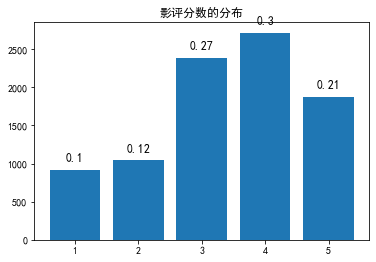

In [15]:
x = np.arange(1,6)
nums = [len(comments[comments['comment_length']==4][comments['star']==i]) for i in x]
plot_score_distribution(x, nums)

In [16]:
comments[comments['comment_length']==4][['comment','star']][:20]

,comment,star
4,中二得很,1
67,3d扣分,2
141,爱与坚持,3
162,勇敢面对,4
180,励志大片,5
208,MIT？,4
220,MIT？,4
251,平民励志,4
258,平民励志,4
265,苦尽甘来,4


# 文本向量化

#### 词向量
- 使用中文维基的预训练词向量

In [17]:
model = Word2Vec.load(model_path)
wv = model.wv
del model

In [18]:
len(wv.vocab)

845989

In [19]:
wv.most_similar(['吴京'])

[('张静初', 0.8863259553909302),
 ('刘烨', 0.8568055629730225),
 ('廖凡', 0.8530554175376892),
 ('张震', 0.8500816822052002),
 ('张涵予', 0.8481923341751099),
 ('胡军', 0.8465080857276917),
 ('段奕宏', 0.8462876081466675),
 ('黄轩', 0.844296932220459),
 ('黄渤', 0.8436167240142822),
 ('喻亢', 0.8426705598831177)]

In [20]:
index = wv.index2word.index('吴京')
index

48404

#### 创建词汇表

In [21]:
def build_vocab(texts):
    vocab = {}
    for t in texts:
        words = t.strip().split()
        for word in words:
            if word != 'unkown':
                vocab[word] = vocab.get(word, 0) + 1
    return vocab

In [22]:
vocab = build_vocab(comments['cleaned_comment'])
vocab

{'吴京': 279,
 '意淫': 279,
 '到': 10358,
 '了': 102050,
 '脑残': 316,
 '的': 328370,
 '地步': 197,
 '看': 34252,
 '恶心': 922,
 '想': 7471,
 '吐': 565,
 '首映礼': 42,
 '太': 12975,
 '恐怖': 596,
 '这个': 10269,
 '电影': 34593,
 '不讲道理': 8,
 '完全': 4152,
 '就是': 14014,
 '在': 31161,
 '实现': 270,
 '他': 10655,
 '小': 6647,
 '粉红': 39,
 '英雄': 1705,
 '梦': 871,
 '各种': 3136,
 '装备': 80,
 '轮番': 21,
 '上场': 17,
 '视': 29,
 '物理': 63,
 '逻辑': 1414,
 '于': 1783,
 '不顾': 57,
 '不得不': 670,
 '说': 11123,
 '有钱': 205,
 '真': 5180,
 '好': 22827,
 '随意': 170,
 '胡闹': 45,
 '炒作': 70,
 '水平': 819,
 '不输': 48,
 '冯小刚': 266,
 '但小刚': 1,
 '至少': 912,
 '不会': 2684,
 '用': 3944,
 '主旋律': 923,
 '来': 5251,
 '让': 13704,
 '人': 24157,
 '不': 28318,
 '舒服': 607,
 '为了': 3506,
 '而': 6535,
 '煽情': 1171,
 '觉得': 8878,
 '是': 72707,
 '个': 6664,
 '大': 5911,
 '做作': 822,
 '谎言': 266,
 '家': 564,
 '7': 1719,
 '29': 96,
 '更新': 87,
 '片子': 9578,
 '整体': 1410,
 '不如': 1795,
 '湄公河': 57,
 '行动': 187,
 '1': 3510,
 '不够': 1818,
 '流畅': 699,
 '编剧': 2270,
 '有毒': 38,
 '台词': 2368,
 '尴尬': 1655,
 '2': 3

In [23]:
print("评论总单词数：{}；词汇表单词个数：{}".format(sum(vocab.values()), len(vocab)))

评论总单词数：4558546；词汇表单词个数：139721


In [24]:
word2index = {'unkown':0}
for word,_ in vocab.items():
    word2index[word] = len(word2index)

In [25]:
word2index

{'unkown': 0,
 '吴京': 1,
 '意淫': 2,
 '到': 3,
 '了': 4,
 '脑残': 5,
 '的': 6,
 '地步': 7,
 '看': 8,
 '恶心': 9,
 '想': 10,
 '吐': 11,
 '首映礼': 12,
 '太': 13,
 '恐怖': 14,
 '这个': 15,
 '电影': 16,
 '不讲道理': 17,
 '完全': 18,
 '就是': 19,
 '在': 20,
 '实现': 21,
 '他': 22,
 '小': 23,
 '粉红': 24,
 '英雄': 25,
 '梦': 26,
 '各种': 27,
 '装备': 28,
 '轮番': 29,
 '上场': 30,
 '视': 31,
 '物理': 32,
 '逻辑': 33,
 '于': 34,
 '不顾': 35,
 '不得不': 36,
 '说': 37,
 '有钱': 38,
 '真': 39,
 '好': 40,
 '随意': 41,
 '胡闹': 42,
 '炒作': 43,
 '水平': 44,
 '不输': 45,
 '冯小刚': 46,
 '但小刚': 47,
 '至少': 48,
 '不会': 49,
 '用': 50,
 '主旋律': 51,
 '来': 52,
 '让': 53,
 '人': 54,
 '不': 55,
 '舒服': 56,
 '为了': 57,
 '而': 58,
 '煽情': 59,
 '觉得': 60,
 '是': 61,
 '个': 62,
 '大': 63,
 '做作': 64,
 '谎言': 65,
 '家': 66,
 '7': 67,
 '29': 68,
 '更新': 69,
 '片子': 70,
 '整体': 71,
 '不如': 72,
 '湄公河': 73,
 '行动': 74,
 '1': 75,
 '不够': 76,
 '流畅': 77,
 '编剧': 78,
 '有毒': 79,
 '台词': 80,
 '尴尬': 81,
 '2': 82,
 '刻意': 83,
 '显得': 84,
 '如此': 85,
 '不合时宜': 86,
 '又': 87,
 '多余': 88,
 '凭良心说': 89,
 '看到': 90,
 '不像': 91,
 '战狼': 92,
 

#### 评论中没有词向量中的词
- 解决措施：继续分词
- 拼写纠错：如“鸡冻”--> “激动”

In [26]:
def check_coverage(vocab, wv):
    known_words = {}
    unknown_words = {}
    no_known_words = 0
    no_unknown_words = 0
    for word in vocab:
        try:
            known_words[word] = wv[word]
            no_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            no_unknown_words += vocab[word]
    print('词汇表中 {:.2%} 的单词有词向量'.format(len(known_words) / len(vocab)))
    print('评论的所有单词中 {:.2%} 的单词有词向量'.format(
        no_known_words / (no_known_words + no_unknown_words)))
    unknown_words = sorted(unknown_words.items(),
                           key=operator.itemgetter(1))[::-1]
    return unknown_words

In [27]:
unknown_words = check_coverage(vocab, wv)

词汇表中 69.33% 的单词有词向量
评论的所有单词中 97.05% 的单词有词向量


In [28]:
len(unknown_words)

42851

In [29]:
sorted(unknown_words, key=lambda w:len(w[0]), reverse=True)[:50]

[('ahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhotdwarvesatyourservice',
  1),
 ('blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah',
  1),
 ('hiusjufbjijhjjsfightdjsiosnwnbombsisjwnexplosionwhshbdbwwhatfuckjusthappenddhsjsndhdjfighrekizjekilldbiejsshotdhsjsnthatbitchsjdjjffuckjejsh',
  1),
 ('bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbest',
  2),
 ('bce43fd38b93b6c518d056245a8a4de28880c502e41eebc1978142bcb20fadc9bc54d7cbb6a0',
  1),
 ('prprprprprprprprprprprprprprprprprprprprpr', 2),
 ('97db28f635ac65285bac7790ca7a36ca2234679201', 1),
 ('3a3e3c800a74582d2295df84c6624848bd6ed54a', 2),
 ('4ee833da28c2d1

In [30]:
sorted(unknown_words, key=lambda w:w[1], reverse=True)[:50]

[('2', 3789),
 ('3', 3620),
 ('1', 3510),
 ('5', 3353),
 ('4', 2237),
 ('7', 1719),
 ('8', 1516),
 ('10', 1476),
 ('6', 1216),
 ('3d', 1055),
 ('0', 919),
 ('9', 822),
 ('20', 660),
 ('12', 535),
 ('90', 501),
 ('30', 445),
 ('加一星', 443),
 ('11', 432),
 ('星给', 420),
 ('80', 413),
 ('一般般', 410),
 ('⋯', 386),
 ('15', 341),
 ('100', 340),
 ('007', 322),
 ('13', 315),
 ('50', 272),
 ('2016', 269),
 ('2008', 268),
 ('2012', 260),
 ('2015', 249),
 ('2014', 242),
 ('2013', 239),
 ('14', 236),
 ('’', 233),
 ('18', 228),
 ('17', 226),
 ('60', 223),
 ('cctv6', 216),
 ('21', 213),
 ('2010', 210),
 ('太赞', 209),
 ('╯', 205),
 ('2017', 205),
 ('70', 204),
 ('￣', 203),
 ('‘', 202),
 ('2009', 201),
 ('没劲', 200),
 ('╰', 198)]

In [31]:
'2' in wv

False

##### 没有词向量的汉语短语

In [32]:
def is_chinese(str):
    for s in str:
        if u'\u4e00' <= s <= u'\u9fff':
            return True
    return False

In [33]:
is_chinese('君子之交淡如水')

True

In [34]:
unknown_chinese=[(w,c) for w, c in unknown_words if is_chinese(w)]
len(unknown_chinese)

37180

In [35]:
sorted(unknown_chinese, key=lambda w:len(w[0]), reverse=True)[:10]

[('九百六十万平方公里', 1),
 ('丈二和尚摸不着头脑', 1),
 ('穷人的孩子早当家', 1),
 ('百尺竿头更进一步', 1),
 ('八仙过海各显神通', 1),
 ('君子之交淡如水', 10),
 ('树欲静而风不止', 7),
 ('竹篮打水一场空', 7),
 ('天生我材必有用', 4),
 ('天下乌鸦一般黑', 3)]

In [36]:
sorted(unknown_chinese, key=lambda w:w[1], reverse=True)[:10]

[('加一星', 443),
 ('星给', 420),
 ('一般般', 410),
 ('太赞', 209),
 ('没劲', 200),
 ('带感', 177),
 ('尿点', 155),
 ('脑残粉', 152),
 ('残粉', 146),
 ('看得人', 146)]

- 没有词向量的汉语短语，前向最大匹配继续分词

In [37]:
def cut(text):
    words = []
    while text:
        seg = text
        n = len(seg)
        for j in range(n, 0, -1):
            w = seg[:j]
            if w in wv:
                words.append(w)
                text = text[j:]
                break
            if len(w) == 1 and not w.isspace():
                text = text[j:]
    return words

In [38]:
for w, _ in sorted(unknown_chinese, key=lambda w: len(w[0]),
                   reverse=True)[:10]:
    print(cut(w))

['九百', '六十万', '平方公里']
['丈二', '和尚', '摸不着头脑']
['穷人', '的', '孩子', '早', '当家']
['百尺竿头', '更进一步']
['八仙过海', '各显神通']
['君子之交', '淡如水']
['树', '欲', '静', '而风', '不止']
['竹篮', '打水', '一场空']
['天生', '我材', '必有用']
['天下', '乌鸦', '一般', '黑']


In [39]:
for w, _ in sorted(unknown_chinese, key=lambda w: w[1], reverse=True)[:10]:
    print(cut(w))

['加一', '星']
['星', '给']
['一般', '般']
['太', '赞']
['没', '劲']
['带', '感']
['尿', '点']
['脑残', '粉']
['残', '粉']
['看得', '人']


##### 全英文字符短语

In [40]:
def is_string(str):
    for s in str:
        if s not in string.ascii_lowercase:
            return False
    return True

In [41]:
unknown_string=[(w,c) for w, c in unknown_words if is_string(w)]
len(unknown_string)

2306

In [42]:
unknown_string

[('dvdrip', 70),
 ('bdrip', 18),
 ('ccav', 17),
 ('bjiff', 15),
 ('hitchitsch', 15),
 ('btih', 15),
 ('johnnydepp', 14),
 ('jlo', 13),
 ('xxoo', 13),
 ('nnd', 13),
 ('willsmith', 12),
 ('xmen', 12),
 ('yyets', 12),
 ('mdzz', 12),
 ('kevinspacey', 10),
 ('exm', 10),
 ('clinteastwood', 10),
 ('mlgb', 10),
 ('happyending', 9),
 ('blabla', 9),
 ('prpr', 9),
 ('qwq', 9),
 ('tomhanks', 9),
 ('megryan', 8),
 ('cinematheque', 8),
 ('xddd', 8),
 ('jimcarrey', 8),
 ('dxy', 7),
 ('rylance', 7),
 ('woodyallen', 7),
 ('bluesliver', 7),
 ('robertdeniro', 7),
 ('congroo', 7),
 ('gscas', 7),
 ('jasonstatham', 7),
 ('quq', 7),
 ('balmes', 7),
 ('undatable', 6),
 ('undateable', 6),
 ('depressing', 6),
 ('kyxq', 6),
 ('amiable', 6),
 ('bingbong', 6),
 ('clotaire', 6),
 ('angelinajolie', 6),
 ('hughjackman', 6),
 ('qmdb', 6),
 ('timburton', 6),
 ('prevarticle', 6),
 ('maggieq', 6),
 ('nicolascage', 6),
 ('tnnd', 6),
 ('piapiapia', 6),
 ('vikander', 6),
 ('hanmeimei', 6),
 ('panzerlied', 5),
 ('agyness', 5

In [43]:
for w,_ in unknown_string[:10]:
    print(cut(w))

['dvd', 'rip']
['bdr', 'ip']
['cca', 'v']
['bji', 'ff']
['hitch', 'its', 'ch']
['bti', 'h']
['johnny', 'depp']
['jl', 'o']
['xxo', 'o']
['nn', 'd']


##### 其它

In [44]:
unknown_others = list(
    set(unknown_words) - set(unknown_chinese) - set(unknown_string))
unknown_others

[('50min', 2),
 ('😛', 2),
 ('ao3', 1),
 ('25am', 1),
 ('1dfd74a56054b289a4a244630d7ed1e70687f21b', 2),
 ('d6b6d9084ddc8542b188f6681d1c085f51dfb7e1', 1),
 ('1280187535', 1),
 ('📘', 3),
 ('123', 14),
 ('ac888256', 1),
 ('718', 1),
 ('d3', 3),
 ('50pm', 2),
 ('12cinema', 1),
 ('20070629', 2),
 ('180g', 1),
 ('0622', 1),
 ('ucta7et0ric', 1),
 ('478', 1),
 ('20150426', 1),
 ('20170513', 1),
 ('〒', 6),
 ('219', 1),
 ('1300', 5),
 ('╥', 10),
 ('20101024', 2),
 ('432', 2),
 ('3dcg', 1),
 ('👲', 4),
 ('1500w', 2),
 ('5788', 1),
 ('９', 6),
 ('5790', 1),
 ('2012sep3', 1),
 ('3018307', 2),
 ('20120821', 1),
 ('20100818', 1),
 ('25308321', 1),
 ('t13329271', 1),
 ('38022383', 1),
 ('8133320', 1),
 ('ntk2mdu0mty', 1),
 ('゜', 7),
 ('f7', 1),
 ('20150412', 2),
 ('283013556', 1),
 ('60', 223),
 ('tlf624', 2),
 ('159', 4),
 ('6200', 1),
 ('7540318', 1),
 ('tt0141926', 1),
 ('40min', 2),
 ('0sb4qvqvu', 1),
 ('2100', 1),
 ('1i510mfj', 1),
 ('3h', 2),
 ('602f80db0100e5eh', 2),
 ('571', 10),
 ('20131127imax'

In [45]:
cleaned_unknown = {}
i = 0
for w, _ in unknown_words:
    # 删除重复字母
    pat1 = re.compile(r"([a-z])(\1{3,})")
    # 删除重复的字符串
    pat2 = re.compile(r"(\w+)(\1{2,}?)")
    t1 = pat1.sub(r"\1", w)
    t2 = pat1.sub(r"\1", w)
    if t1 != w:
        cleaned_unknown[w] = t1
    else:
        if t2 != w:
            cleaned_unknown[w] = t2

#### 重新处理文本

In [46]:
def cut_join(text):
    results = []
    space = ' '
    seg_list = jieba.cut(text)
    for w in seg_list:
        if w in wv:
            results.append(w)
        else:
            if is_chinese(w):
                words = cut(w)
                results.extend(words)
            elif is_string(w):
                words = cut(w)
                unique = []
                for w in words:
                    if w not in unique:
                        unique.append(w)
                results.extend(unique)
    return space.join(results)

In [47]:
list(jieba.cut('12abc43 九百六十万平方公里 pbocyq5ccfs woow'))

['12abc43', ' ', '九百六十万平方公里', ' ', 'pbocyq5ccfs', ' ', 'woow']

In [48]:
cut_join('12abc43 九百六十万平方公里 pbocyq5ccfs woow')

'九百 六十万 平方公里 woo w'

In [49]:
comments['cleaned_comment'] = comments['comment'].apply(preprocess)

In [50]:
vocab = build_vocab(comments['cleaned_comment'])
vocab

{'吴京': 312,
 '意淫': 279,
 '到': 10929,
 '了': 102423,
 '脑残': 503,
 '的': 328489,
 '地步': 199,
 '看': 35779,
 '恶心': 924,
 '想': 7766,
 '吐': 608,
 '首映礼': 42,
 '太': 15646,
 '恐怖': 596,
 '这个': 10269,
 '电影': 34739,
 '不讲道理': 8,
 '完全': 4152,
 '就是': 14014,
 '在': 31277,
 '实现': 270,
 '他': 10737,
 '小': 7156,
 '粉红': 39,
 '英雄': 1714,
 '梦': 911,
 '各种': 3136,
 '装备': 80,
 '轮番': 21,
 '上场': 17,
 '视': 43,
 '物理': 63,
 '逻辑': 1415,
 '于': 1845,
 '不顾': 63,
 '不得不': 670,
 '说': 11437,
 '有钱': 207,
 '真': 6293,
 '好': 24326,
 '随意': 170,
 '胡闹': 66,
 '炒作': 76,
 '水平': 825,
 '不输': 52,
 '冯小刚': 266,
 '但': 15677,
 '小刚': 22,
 '至少': 912,
 '不会': 2684,
 '用': 4223,
 '主旋律': 923,
 '来': 5912,
 '让': 13756,
 '人': 24861,
 '不': 29017,
 '舒服': 628,
 '为了': 3506,
 '而': 6686,
 '煽情': 1173,
 '觉得': 8881,
 '是': 73132,
 '个': 7505,
 '大': 6303,
 '做作': 822,
 '谎言': 266,
 '家': 668,
 '更新': 87,
 '片子': 9578,
 '整体': 1410,
 '不如': 1796,
 '湄公河': 57,
 '行动': 187,
 '不够': 1818,
 '流畅': 699,
 '编剧': 2270,
 '有毒': 38,
 '台词': 2368,
 '尴尬': 1655,
 '刻意': 1040,
 '显得': 1098,
 '如

In [51]:
check_coverage(vocab, wv)

词汇表中 100.00% 的单词有词向量
评论的所有单词中 100.00% 的单词有词向量


[]

In [52]:
word2index = {'unkown':0}
for word,_ in vocab.items():
    word2index[word] = len(word2index)
word2index    

{'unkown': 0,
 '吴京': 1,
 '意淫': 2,
 '到': 3,
 '了': 4,
 '脑残': 5,
 '的': 6,
 '地步': 7,
 '看': 8,
 '恶心': 9,
 '想': 10,
 '吐': 11,
 '首映礼': 12,
 '太': 13,
 '恐怖': 14,
 '这个': 15,
 '电影': 16,
 '不讲道理': 17,
 '完全': 18,
 '就是': 19,
 '在': 20,
 '实现': 21,
 '他': 22,
 '小': 23,
 '粉红': 24,
 '英雄': 25,
 '梦': 26,
 '各种': 27,
 '装备': 28,
 '轮番': 29,
 '上场': 30,
 '视': 31,
 '物理': 32,
 '逻辑': 33,
 '于': 34,
 '不顾': 35,
 '不得不': 36,
 '说': 37,
 '有钱': 38,
 '真': 39,
 '好': 40,
 '随意': 41,
 '胡闹': 42,
 '炒作': 43,
 '水平': 44,
 '不输': 45,
 '冯小刚': 46,
 '但': 47,
 '小刚': 48,
 '至少': 49,
 '不会': 50,
 '用': 51,
 '主旋律': 52,
 '来': 53,
 '让': 54,
 '人': 55,
 '不': 56,
 '舒服': 57,
 '为了': 58,
 '而': 59,
 '煽情': 60,
 '觉得': 61,
 '是': 62,
 '个': 63,
 '大': 64,
 '做作': 65,
 '谎言': 66,
 '家': 67,
 '更新': 68,
 '片子': 69,
 '整体': 70,
 '不如': 71,
 '湄公河': 72,
 '行动': 73,
 '不够': 74,
 '流畅': 75,
 '编剧': 76,
 '有毒': 77,
 '台词': 78,
 '尴尬': 79,
 '刻意': 80,
 '显得': 81,
 '如此': 82,
 '不合时宜': 83,
 '又': 84,
 '多余': 85,
 '凭良心说': 86,
 '看到': 87,
 '不像': 88,
 '战狼': 89,
 '续集': 90,
 '完虐': 91,
 '中二': 92,


In [53]:
index2word = {ind:w for w,ind in word2index.items()}
index2word

{0: 'unkown',
 1: '吴京',
 2: '意淫',
 3: '到',
 4: '了',
 5: '脑残',
 6: '的',
 7: '地步',
 8: '看',
 9: '恶心',
 10: '想',
 11: '吐',
 12: '首映礼',
 13: '太',
 14: '恐怖',
 15: '这个',
 16: '电影',
 17: '不讲道理',
 18: '完全',
 19: '就是',
 20: '在',
 21: '实现',
 22: '他',
 23: '小',
 24: '粉红',
 25: '英雄',
 26: '梦',
 27: '各种',
 28: '装备',
 29: '轮番',
 30: '上场',
 31: '视',
 32: '物理',
 33: '逻辑',
 34: '于',
 35: '不顾',
 36: '不得不',
 37: '说',
 38: '有钱',
 39: '真',
 40: '好',
 41: '随意',
 42: '胡闹',
 43: '炒作',
 44: '水平',
 45: '不输',
 46: '冯小刚',
 47: '但',
 48: '小刚',
 49: '至少',
 50: '不会',
 51: '用',
 52: '主旋律',
 53: '来',
 54: '让',
 55: '人',
 56: '不',
 57: '舒服',
 58: '为了',
 59: '而',
 60: '煽情',
 61: '觉得',
 62: '是',
 63: '个',
 64: '大',
 65: '做作',
 66: '谎言',
 67: '家',
 68: '更新',
 69: '片子',
 70: '整体',
 71: '不如',
 72: '湄公河',
 73: '行动',
 74: '不够',
 75: '流畅',
 76: '编剧',
 77: '有毒',
 78: '台词',
 79: '尴尬',
 80: '刻意',
 81: '显得',
 82: '如此',
 83: '不合时宜',
 84: '又',
 85: '多余',
 86: '凭良心说',
 87: '看到',
 88: '不像',
 89: '战狼',
 90: '续集',
 91: '完虐',
 92: '中二',


#### 将文本转化成向量

In [54]:
def sent2vec(sent):
    words = sent.strip().split()
    return [word2index[w] for w in words]

In [55]:
comments['cleaned_comment'].iloc[2]

'吴京 的 炒作 水平 不输 冯小刚 但 小刚 至少 不会 用 主旋律 来 炒作 吴京 让 人 看 了 不 舒服 为了 主旋律 而 主旋律 为了 煽情 而 煽情 让 人 觉得 他 是 个 大 做作 大 谎言 家 更新 片子 整体 不如 湄公河 行动 整体 不够 流畅 编剧 有毒 台词 尴尬 刻意 做作 的 主旋律 煽情 显得 如此 不合时宜 而 又 多余'

In [56]:
sent2vec(comments['cleaned_comment'].iloc[2])

[1,
 6,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 43,
 1,
 54,
 55,
 8,
 4,
 56,
 57,
 58,
 52,
 59,
 52,
 58,
 60,
 59,
 60,
 54,
 55,
 61,
 22,
 62,
 63,
 64,
 65,
 64,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 70,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 65,
 6,
 52,
 60,
 81,
 82,
 83,
 59,
 84,
 85]

#### 将句子的向量转化成相同长度

In [57]:
X = [sent2vec(sent) for sent in comments['cleaned_comment']]

In [58]:
maxlen=100
X = sequence.pad_sequences(X, maxlen=maxlen)

In [59]:
X

array([[    0,     0,     0, ...,     9,    10,    11],
       [    0,     0,     0, ...,    40,    41,    42],
       [    0,     0,     0, ...,    59,    84,    85],
       ...,
       [    0,     0,     0, ...,    56,   828,   339],
       [    0,     0,     0, ...,   429,     8,   446],
       [    0,     0,     0, ..., 11072,  6306,     9]], dtype=int32)

In [60]:
X.shape

(248396, 100)

In [61]:
y = comments['star']
y

0         1
1         2
2         2
3         4
4         1
         ..
261492    3
261493    3
261494    2
261495    3
261496    3
Name: star, Length: 248396, dtype: int64

In [62]:
def to_categorical(y):
    y = np.array(y, dtype='int')
    n = len(y)
    m = np.max(y)
    categorical = np.zeros((n, m))
    categorical[np.arange(n), y-1] = 1
    return categorical

In [63]:
y = to_categorical(y)

In [64]:
y

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

#### 嵌入矩阵

In [65]:
embed_size = 50
nb_words = len(vocab)+1
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word2index.items():
    if word in wv:
        vector = wv[word]
        embedding_matrix[i] = vector

embedding_matrix    

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.12430072, -0.39485088, -1.34238815, ...,  2.30412221,
         1.03823328, -1.30636704],
       [ 0.26209503, -0.49268979, -0.51753461, ...,  1.32445359,
        -0.33967397,  0.66318768],
       ...,
       [-0.26862964, -0.23968956,  0.16119906, ...,  0.01158467,
         0.16363347,  0.01866432],
       [ 0.30251694,  0.03766752,  0.73150182, ...,  0.35207793,
        -0.23663767,  0.10812829],
       [-0.04078084, -0.02281673, -0.10331304, ...,  0.08166362,
        -0.16539493, -0.12828492]])

In [66]:
embedding_matrix.shape

(98553, 50)

# 创建模型

## 基准模型

In [67]:
inp = Input(shape=(maxlen, ))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(
    LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(5, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [68]:
history = model.fit(X, y, epochs=2, batch_size=128, validation_split=0.25)

Train on 186297 samples, validate on 62099 samples
Epoch 1/2
186297/186297 [==============================] - 152s 814us/sample - loss: 1.3473 - accuracy: 0.3875 - val_loss: 1.2838 - val_accuracy: 0.4221
Epoch 2/2
186297/186297 [==============================] - 150s 804us/sample - loss: 1.2257 - accuracy: 0.4502 - val_loss: 1.2622 - val_accuracy: 0.4317


#### 五分类转化成三分类

In [69]:
def to3cat(x):
    if x < 3:
        x = 1  # 烂片
    elif x == 3:
        x = 2  # 普通
    else:
        x = 3  # 好片
    return x

In [70]:
y = comments['star'].apply(to3cat)

In [71]:
y = to_categorical(y)
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [72]:
inp = Input(shape=(maxlen, ))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(
    LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [73]:
history = model.fit(X, y, epochs=2, batch_size=128, validation_split=0.25)

Train on 186297 samples, validate on 62099 samples
Epoch 1/2
186297/186297 [==============================] - 156s 840us/sample - loss: 0.8209 - accuracy: 0.6331 - val_loss: 0.8541 - val_accuracy: 0.6168
Epoch 2/2
186297/186297 [==============================] - 155s 831us/sample - loss: 0.7184 - accuracy: 0.6872 - val_loss: 0.7939 - val_accuracy: 0.6434


#### 二分类

In [76]:
def to2cat(x):
    if x <= 3:
        x = 0  # neg
    else:
        x = 1  # pos
    return x

In [77]:
y = comments['star'].apply(to2cat)
y

0         0
1         0
2         0
3         1
4         0
         ..
261492    0
261493    0
261494    0
261495    0
261496    0
Name: star, Length: 248396, dtype: int64

In [78]:
inp = Input(shape=(maxlen, ))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(
    LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X, y, epochs=2, batch_size=128, validation_split=0.25)

True